<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Decicion Tree Classifier
 - <span style="color:dodgerblue;"> **Pros:**
   - <span style="color:black;"> Handling Imbalance ( class_weight={1:N} )
   - <span style="color:black;"> Fast Learner
   - <span style="color:black;"> Decision Tree Plot
 - <span style="color:deeppink;"> **Cons:**
   - <span style="color:black;"> Low Accuracy

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Objective:
 - To detect diabetes using Decision Tree Classifier and Ensemble Methods

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Libraries

In [1]:
import time, pickle
import pyts
import numpy  as np
from   numpy import mean, std

import pandas as pd
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',None)

from matplotlib import pyplot as plt

import seaborn as sns
sns.set(style="ticks", color_codes=True)
 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from imblearn.combine        import SMOTETomek, SMOTEENN
from imblearn.over_sampling  import SMOTE

from sklearn.impute          import KNNImputer 
from sklearn.ensemble        import IsolationForest

from sklearn.feature_selection import chi2

from sklearn.preprocessing   import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing   import MaxAbsScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score

from sklearn.metrics         import accuracy_score, recall_score, precision_score
from sklearn.metrics         import classification_report, ConfusionMatrixDisplay

from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier 
from sklearn.tree            import plot_tree

from sklearn.ensemble        import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from imblearn.ensemble       import EasyEnsembleClassifier 

from sklearn.ensemble        import StackingClassifier, VotingClassifier

import warnings 
warnings.filterwarnings('ignore') 

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Importing Dataset

In [2]:
data = pickle.load( open('df_Clean','rb') )  # load
print(f'there are {data.shape[0]} rows and {data.shape[1]} columns.')
data 

there are 8 rows and 13 columns.


,S0,S1,S2,S3,S4,C2,C3,C4,C5,S5,S6,C0,C1
0,1.716680,1.000000,2.000000,3.000000,3.000000,1.000000,0.197101,0.000000,0.000000,NaN,C2,Lime,Jazz
1,1.100000,1.389134,1.000000,5.000000,4.000000,0.000000,0.000000,1.581701,1.000000,C3,NaN,Cyan,Rock
2,2.400000,1.657590,1.000000,4.000000,1.000000,1.000000,0.000000,1.378129,2.000000,C2,NaN,Blue,Pop
3,1.167526,2.000000,1.179369,5.000000,1.000000,0.000000,1.000000,1.000000,1.846123,C3,C2,None,Rock
4,0.500000,1.000000,1.000000,2.994865,4.000000,1.000000,0.000000,2.000000,3.000000,C3,C3,Red,None
5,0.700000,2.000000,1.000000,3.644769,2.000000,1.000000,1.000000,2.000000,3.000000,C1,C3,Red,None
6,0.900000,2.000000,2.000000,2.000000,2.928060,0.807191,0.000000,1.000000,2.000000,C2,C1,Blue,Pop
7,1.800000,1.000000,1.000000,2.000000,3.129929,0.567104,0.000000,3.000000,0.000000,C1,C2,Pink,Jazz


In [3]:
# (input) importing Raw data

data_set_name    = 'Pima_Diabetes'
estimated_column = 'S6'

data_file        = 'Pima_Diabetes.csv'
data_sheet       = 'Pima_Diabetes'

# needed parameters 
RANDOM_STATE     =  3
SCORING          = 'accuracy'

# (auto)
#data = pd.read_csv( data_file, header=0 ) # , delimiter=','
#print(f'there are {data.shape[0]} rows and {data.shape[1]} columns.')

In [4]:
data = data.dropna( subset=[estimated_column] ) 

In [81]:
Classes = list( data[estimated_column].unique() )
Classes.sort()
Classes

['C1', 'C2', 'C3']

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Delete This

In [6]:
data = pd.concat( [data,data,data,data,data], axis=0)
data.index = range(data.shape[0])
data = pd.concat( [data,data,data,data,data], axis=0)
data.index = range(data.shape[0])
data.tail()

,S0,S1,S2,S3,S4,C2,C3,C4,C5,S5,S6,C0,C1
145,1.167526,2.0,1.179369,5.000000,1.000000,0.000000,1.0,1.0,1.846123,C3,C2,None,Rock
146,0.500000,1.0,1.000000,2.994865,4.000000,1.000000,0.0,2.0,3.000000,C3,C3,Red,None
147,0.700000,2.0,1.000000,3.644769,2.000000,1.000000,1.0,2.0,3.000000,C1,C3,Red,None
148,0.900000,2.0,2.000000,2.000000,2.928060,0.807191,0.0,1.0,2.000000,C2,C1,Blue,Pop
149,1.800000,1.0,1.000000,2.000000,3.129929,0.567104,0.0,3.0,0.000000,C1,C2,Pink,Jazz


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Splitting the data into training, validation and test set in the ratio of 60:20:20 respectively.

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Splitting into X and y

In [7]:
X = data.drop([estimated_column], axis=1).copy()  # X_df = data.loc[ :, data.columns != 'Personal Loan' ]  
X = pd.get_dummies( X, columns=X.loc[:,X.dtypes=='object' ].columns ).replace(False,0).replace(True,1)

y = data[estimated_column].copy()                 # y_df = data.loc[ :, data.columns == 'Personal Loan' ]  
y = LabelEncoder().fit_transform( y )

In [8]:
X.tail()

,S0,S1,S2,S3,S4,C2,C3,C4,C5,S5_C1,S5_C2,S5_C3,C0_Blue,C0_Lime,C0_Pink,C0_Red,C1_Jazz,C1_Pop,C1_Rock
145,1.167526,2.0,1.179369,5.000000,1.000000,0.000000,1.0,1.0,1.846123,0,0,1,0,0,0,0,0,0,1
146,0.500000,1.0,1.000000,2.994865,4.000000,1.000000,0.0,2.0,3.000000,0,0,1,0,0,0,1,0,0,0
147,0.700000,2.0,1.000000,3.644769,2.000000,1.000000,1.0,2.0,3.000000,1,0,0,0,0,0,1,0,0,0
148,0.900000,2.0,2.000000,2.000000,2.928060,0.807191,0.0,1.0,2.000000,0,1,0,1,0,0,0,0,1,0
149,1.800000,1.0,1.000000,2.000000,3.129929,0.567104,0.0,3.0,0.000000,1,0,0,0,0,1,0,1,0,0


In [9]:
X.shape

(150, 19)

In [10]:
y[:10]

array([1, 1, 2, 2, 0, 1, 1, 1, 2, 2])

In [11]:
y.shape

(150,)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Splitting into Train, Valid and Test Sets

In [12]:
X_Train, X_ValidTest, y_Train, y_ValidTest  =  train_test_split(        
          X, y
        , random_state  =  RANDOM_STATE
        , test_size     =  30/100
        , shuffle       =  True 
        , stratify      =  y
        )
X_Train.index      = range( X_Train.shape[0] )
X_ValidTest.index  = range( X_ValidTest.shape[0]        ) 

X = X_ValidTest
y = y_ValidTest

X_Valid, X_Test, y_Valid, y_Test  =  train_test_split(        
          X, y
        , random_state  =  RANDOM_STATE
        , test_size     =  50/100
        , shuffle       =  True 
        , stratify      =  y
        )
X_Valid.index = range( X_Valid.shape[0] )
X_Test.index  = range( X_Test.shape[0]  ) 

In [13]:
X_Train.shape

(105, 19)

In [14]:
X_Valid.shape

(22, 19)

In [15]:
X_Test.shape

(23, 19)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Counting Subcats of Sets

In [16]:
pd.crosstab( y_Train, columns='Subcat-Count' )  

col_0,Subcat-Count
row_0,
0,17
1,53
2,35


In [17]:
pd.crosstab( y_Valid, columns='Subcat-Count' )  

col_0,Subcat-Count
row_0,
0,4
1,11
2,7


In [18]:
pd.crosstab( y_Test, columns='Subcat-Count' )  

col_0,Subcat-Count
row_0,
0,4
1,11
2,8


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving Data Sets

In [33]:
pickle.dump( X_Train, open('X_Train','wb') )  # save
pickle.dump( X_Valid, open('X_Valid','wb') )  # save
pickle.dump( X_Test , open('X_Test' ,'wb') )  # save

pickle.dump( y_Train, open('y_Train','wb') )  # save
pickle.dump( y_Valid, open('y_Valid','wb') )  # save
pickle.dump( y_Test , open('y_Test' ,'wb') )  # save

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Data Sets

In [34]:
X_Train = pickle.load( open('X_Train','rb') )  # load
X_Valid = pickle.load( open('X_Valid','rb') )  # load
X_Test  = pickle.load( open('X_Test' ,'rb') )  # load

y_Train = pickle.load( open('y_Train','rb') )  # load
y_Valid = pickle.load( open('y_Valid','rb') )  # load
y_Test  = pickle.load( open('y_Test' ,'rb') )  # load

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Checking Imbalance in Data

col_0  count
S6          
C2        75
C3        50
C1        25


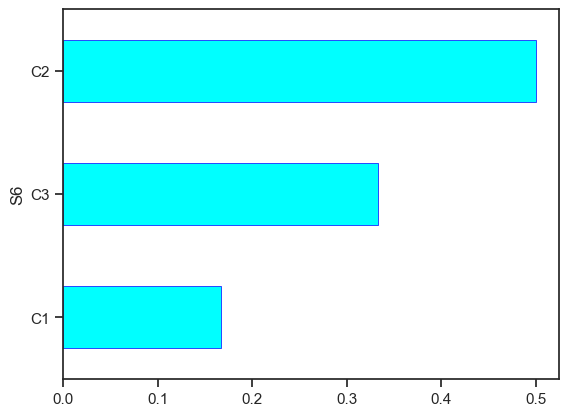

In [19]:
df = data.copy()
x  = estimated_column

# Frequency Table  
freq_tab = pd.crosstab( index=df[x].astype('str'), columns='count' )
print(freq_tab.sort_values('count',ascending=False))

# Barh
L = df[x].astype('str')
L.value_counts(normalize=True).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan'); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - Data is **Imbalanced** and needs treatment.

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:red;"> Mistreating Imbalance

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:red;"> Mistreating Imbalance by SMOTETomek

In [20]:
Sampler = SMOTE( sampling_strategy='auto', k_neighbors=5, random_state=RANDOM_STATE )

X_Train_Balanced, y_Train_Balanced = Sampler.fit_resample( X_Train, y_Train )
X_Train_Balanced.index = range(X_Train_Balanced.shape[0])

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:red;"> Checking Balanced Data

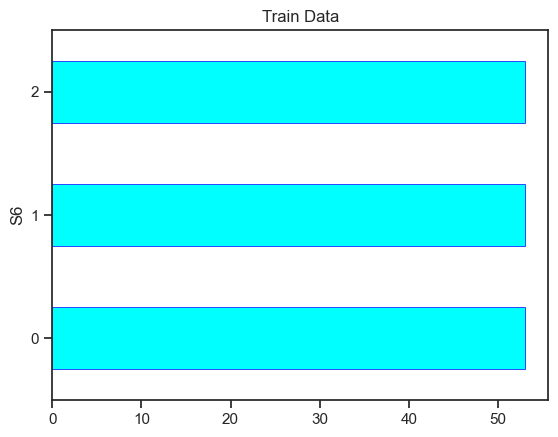

In [21]:
x = estimated_column

df_Train_Balanced      = X_Train_Balanced.copy()
df_Train_Balanced[ x ] = y_Train_Balanced.copy() 

# Train Data
df = df_Train_Balanced.copy() 
L  = df[x].astype('str')
L.value_counts(normalize=False).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan',title='Train Data'); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - After Mistreatment, Data is **Balanced**

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:red;"> Warning: 
 - Although Mistreated Data looks Charming and Tempting, unfortunately, the models trained by them are overfit and have weak performance.
 - A better solution to overcome the imbalance, is to train the models with the imbalanced data, and boost them via gradient-boost.

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:red;"> (NOT) Assigning 

In [22]:
X_Train = X_Train_Balanced.copy()
y_Train = y_Train_Balanced.copy()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving Data Sets

In [23]:
pickle.dump( X_Train_Balanced, open('X_Train_Balanced','wb') )  # save
pickle.dump( y_Train_Balanced, open('y_Train_Balanced','wb') )  # save

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Data Sets

In [35]:
X_Train = pickle.load( open('X_Train_Balanced','rb') )  # load
y_Train = pickle.load( open('y_Train_Balanced','rb') )  # load

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making Decision Tree Estimator

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Finding The Class_Weight
 - A **Class_Weight** is calculated and inserted in Estimators to compensate for **Data Imbalance**.

In [36]:
df = pd.DataFrame([y_Train,y_Train]).T
df.columns = [estimated_column,'del']
df.index = np.arange( df.shape[0] )

freq_tab = pd.crosstab( index=df[estimated_column].astype('str'), columns='count' )
CLASS_WEIGHT = max(freq_tab['count'])/min(freq_tab['count'])
CLASS_WEIGHT

1.0

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Preparing Hyper-Parameters

In [37]:
# Needed Data
N_SPLITS = 10

# Initiating
t1 = time.time()

# cross-validation strategy 
CV = StratifiedKFold( n_splits=N_SPLITS, shuffle=True )

# Hyper Parameters
CATs  = [ ['splitter'    , ['random','best']             ] 
        , ['criterion'   , ['gini','entropy','log_loss'] ] 
        #, ['class_weight', ['balanced',None]             ] 
        , ['max_features', ['sqrt','log2',None]          ]  
        ]
TFs   = [ 
        ]
INTs  = [ ['max_depth'     ,   1,  4,  4  ]
        , ['max_leaf_nodes',   2, 16, 15  ]
        ]
CONTs = [ [ 'ccp_alpha'               ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_samples_leaf'        ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_samples_split'       ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_impurity_decrease'   ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_weight_fraction_leaf',   1e-3, 0.5, 12,   'log-uniform' ]
        ] 
            
# General Estimator
ESTIMATOR  =  DecisionTreeClassifier( class_weight = {1:CLASS_WEIGHT}
                                    , random_state =   RANDOM_STATE 
                                    ) 

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Defining Genetic Algorithm Optimizer

In [38]:
# pip install sklearn-genetic-opt
from sklearn_genetic           import GAFeatureSelectionCV, GASearchCV
from sklearn_genetic.callbacks import LogbookSaver, ProgressBar
from sklearn_genetic.space     import Categorical as GA_Categorical 
from sklearn_genetic.space     import Integer     as GA_Integer 
from sklearn_genetic.space     import Continuous  as GA_Continuous 
from sklearn_genetic.plots     import plot_fitness_evolution
from sklearn_genetic.plots     import plot_search_space

# defining G.A. Optimizer
def GA_Search( CATs,TFs,INTs,CONTs, ESTIMATOR,CV,Search_Space_Features,SCORING
             , Pop_Size,   Gens,   Tours,   Crossover,   Mutation
             , X_Train_Scaled, y_Train, X_Valid_Scaled, y_Valid ):
    
    callbacks = [LogbookSaver( checkpoint_path="./GA_logbook_DTree.pkl"),ProgressBar()]
    
    param_grid = {}
    for item in CATs:  param_grid[item[0]]=GA_Categorical(item[1])
    for item in TFs:   param_grid[item[0]]=GA_Categorical([True,False])
    for item in INTs:  param_grid[item[0]]=GA_Integer(item[1],item[2])
    for item in CONTs: param_grid[item[0]]=GA_Continuous(item[1],item[2],distribution=item[4])

    optimal_params = GASearchCV(
          estimator=ESTIMATOR, cv=CV, param_grid=param_grid, scoring=SCORING, population_size=Pop_Size
        , generations=Gens, tournament_size=Tours, elitism=True, keep_top_k=10, crossover_probability=Crossover
        , mutation_probability=Mutation, criteria="max", algorithm="eaMuCommaLambda", n_jobs=-1 ) 

    print('initiating ...')
    optimal_params.fit( X_Train_Scaled, y_Train, callbacks = callbacks )

    accuracy = optimal_params.score( X_Valid_Scaled, y_Valid )  
    print('\n\nBest Parameters:', optimal_params.best_params_)
    print('accuracy =', accuracy)
    
    plot_search_space( optimal_params, features=Search_Space_Features )
    plt.show()           
        
    Top_Params = optimal_params.logbook.chapters["parameters"]    
    return [ optimal_params.best_params_ , Top_Params ]

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Tuning Hyper-Parameters
 - <span style="color:deeppink;"> **Note:** Data is NOT scaled

initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	5     	0.674167	0.30838    	1          	0.314583   
1  	9     	1       	0          	1          	1          
2  	9     	1       	0          	1          	1          


Best Parameters: {'splitter': 'best', 'criterion': 'gini', 'max_features': 'log2', 'max_depth': 4, 'max_leaf_nodes': 13, 'ccp_alpha': 0.002992953890535522, 'min_samples_leaf': 0.06561731011338934, 'min_samples_split': 0.0034756337820315295, 'min_impurity_decrease': 0.03431398835691451, 'min_weight_fraction_leaf': 0.006759396235128741}
accuracy = 1.0


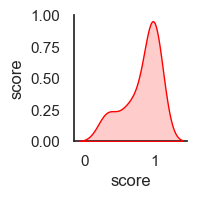


optimizing_time (min) = 0.0


In [28]:
# Initiating
t1 = time.time()

### Optimizing by G.A.
Pop_Size, Gens, Tours, Crossover, Mutation = 500,2,1500, .30,.60 
Search_Space_Features   = [ 'score' ]
Best_Params, Top_Params = GA_Search(CATs,TFs,INTs,CONTs,ESTIMATOR,CV,Search_Space_Features,SCORING,
                                    Pop_Size,Gens,Tours,Crossover,Mutation,
                                    X_Train, y_Train, X_Valid, y_Valid )     ###  Note: Data is NOT scaled  ###

t2 = time.time()
dt = np.round( (t2-t1)/60, 0 )
print( '\noptimizing_time (min) =', dt )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making DTree
 - <span style="color:deeppink;"> **Note:** Data is NOT scaled

In [39]:
DTree = DecisionTreeClassifier(
    splitter='best', criterion='gini', max_features='log2', max_depth=4, max_leaf_nodes=13, 
    ccp_alpha=0.002992953890535522, min_samples_leaf=0.06561731011338934, min_samples_split=0.0034756337820315295,
    min_impurity_decrease=0.03431398835691451, min_weight_fraction_leaf=0.006759396235128741,
    class_weight={1:CLASS_WEIGHT}, random_state=RANDOM_STATE 
                               ).fit( X_Train, y_Train )     ###  Note: Data is NOT scaled  ###

pickle.dump( DTree,  open('DTree','wb') )  # save
DTree = pickle.load( open('DTree','rb') )  # load

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Plotting DTree
 - Install the following libraries:
    - pip install pydotplus
    - conda install graphviz
 - <span style="color:deeppink;"> **Note:** Data is NOT scaled

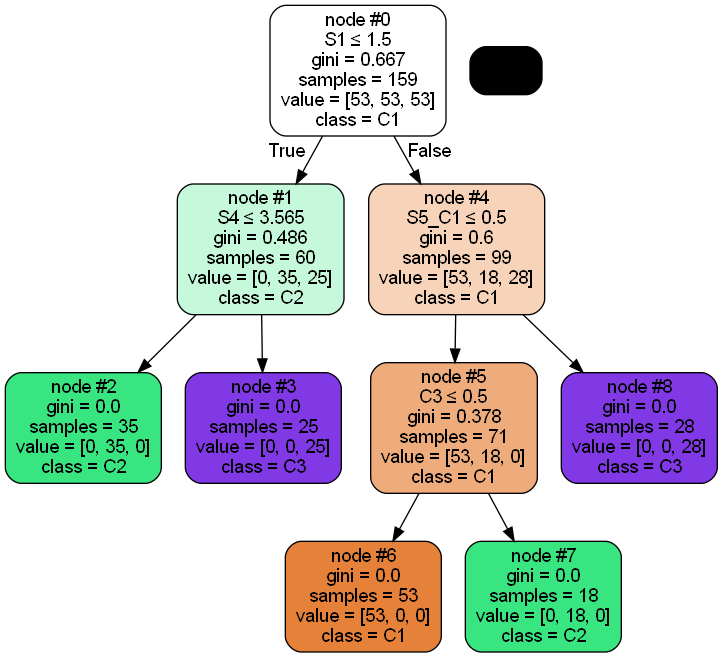

In [40]:
# Old Method (Simple, But Depricated)
''' 
plt.figure( figsize=(14,6) )
plot_tree(  decision_tree  =  DTree
         ,  filled         =  True
         ,  rounded        =  True
         ,  fontsize       =  9
         ,  precision      =  1
         ,  class_names    =  ['No','Yes']
         ,  feature_names  =  X_Train.columns 
         ) 
plt.savefig( 'DTree_Plot.png',  dpi=120 )
plt.show() 
''' 

# New Method (Hard, But Modern)
import six
import sys
sys.modules['sklearn.externals.six'] = six

from sklearn.externals.six import StringIO
from IPython.display       import Image
from sklearn.tree          import export_graphviz
import pydotplus 

dot_data = StringIO()
export_graphviz( DTree, feature_names=X_Train.columns,  special_characters=True,  class_names=Classes,
                 out_file=dot_data,  filled=True,  rounded=True,  node_ids=True )
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png('DTree.png')   # Saving as png
graph.write_pdf('DTree.pdf')   # Saving as pdf

# Generate .png image of "Decision Tree"
Image( graph.create_png() )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Precision & Recall of DTree

In [41]:
y_Pred_DTree = DTree.predict( X_Valid )
DTree_Report = classification_report( y_Valid, y_Pred_DTree )
print( '\nDTree\n', DTree_Report ) 


DTree
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - By Optimization:
    - **Precision** of **Class 0** Improved **+4 %**
    - **Precision** of **Class 1** Improved **+4 %**
    - **Recall** of **Class 0** Improved **0 %**
    - **Recall** of **Class 1** Improved **+9 %**
    - **Accuracy** of **Model** Improved **+3 %**
****
 - Accuracy, Recall or Precision **< 80%** and need Boosting.

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> PCA
   

In [43]:
from sklearn.decomposition import PCA

In [44]:
pca = PCA().fit( X_Train )   # X_Train = X_Train_Balanced

pickle.dump( pca,  open('pca','wb') )  # save
pca = pickle.load( open('pca','rb') )  # load
pca

PCA()

In [45]:
X_Train_PCA = pca.transform(    X_Train    )
X_Train_PCA = np.column_stack(( X_Train_PCA[:,0], 
                                X_Train_PCA[:,1], 
                                X_Train_PCA[:,2] ))
X_Train_PCA = pd.DataFrame(     X_Train_PCA, columns=['pca1','pca2','pca3'] )
X_Train_PCA = pd.concat(       [X_Train_PCA,
                                X_Train]   , axis=1 )

pickle.dump( X_Train_PCA,  open('X_Train_PCA','wb') )  # save
X_Train_PCA = pickle.load( open('X_Train_PCA','rb') )  # load
X_Train_PCA.tail()

,pca1,pca2,pca3,S0,S1,S2,S3,S4,C2,C3,C4,C5,S5_C1,S5_C2,S5_C3,C0_Blue,C0_Lime,C0_Pink,C0_Red,C1_Jazz,C1_Pop,C1_Rock
154,0.636385,-0.701189,-1.770039,0.5,1.0,1.0,2.994865,4.0,1.0,0.0,2.0,3.0,0,0,1,0,0,0,1,0,0,0
155,0.636385,-0.701189,-1.770039,0.5,1.0,1.0,2.994865,4.0,1.0,0.0,2.0,3.0,0,0,1,0,0,0,1,0,0,0
156,1.909536,-0.046882,-0.551801,0.7,2.0,1.0,3.644769,2.0,1.0,1.0,2.0,3.0,1,0,0,0,0,0,1,0,0,0
157,1.909536,-0.046882,-0.551801,0.7,2.0,1.0,3.644769,2.0,1.0,1.0,2.0,3.0,1,0,0,0,0,0,1,0,0,0
158,1.909536,-0.046882,-0.551801,0.7,2.0,1.0,3.644769,2.0,1.0,1.0,2.0,3.0,1,0,0,0,0,0,1,0,0,0


In [46]:
X_Valid_PCA = pca.transform(    X_Valid    )
X_Valid_PCA = np.column_stack(( X_Valid_PCA[:,0], 
                                X_Valid_PCA[:,1], 
                                X_Valid_PCA[:,2] ))
X_Valid_PCA = pd.DataFrame(     X_Valid_PCA, columns=['pca1','pca2','pca3'] )
X_Valid_PCA = pd.concat(       [X_Valid_PCA,
                                X_Valid]   , axis=1 )

pickle.dump( X_Valid_PCA,  open('X_Valid_PCA','wb') )  # save
X_Valid_PCA = pickle.load( open('X_Valid_PCA','rb') )  # load
X_Valid_PCA.tail()

,pca1,pca2,pca3,S0,S1,S2,S3,S4,C2,C3,C4,C5,S5_C1,S5_C2,S5_C3,C0_Blue,C0_Lime,C0_Pink,C0_Red,C1_Jazz,C1_Pop,C1_Rock
17,1.909536,-0.046882,-0.551801,0.70000,2.0,1.0,3.644769,2.00000,1.000000,1.000000,2.0,3.0,1,0,0,0,0,0,1,0,0,0
18,-1.040690,-1.312509,0.627310,0.90000,2.0,2.0,2.000000,2.92806,0.807191,0.000000,1.0,2.0,0,1,0,1,0,0,0,0,1,0
19,-1.475164,1.491563,1.338982,1.71668,1.0,2.0,3.000000,3.00000,1.000000,0.197101,0.0,0.0,0,0,0,0,1,0,0,1,0,0
20,0.636385,-0.701189,-1.770039,0.50000,1.0,1.0,2.994865,4.00000,1.000000,0.000000,2.0,3.0,0,0,1,0,0,0,1,0,0,0
21,1.909536,-0.046882,-0.551801,0.70000,2.0,1.0,3.644769,2.00000,1.000000,1.000000,2.0,3.0,1,0,0,0,0,0,1,0,0,0


In [47]:
X_Test_PCA = pca.transform(    X_Test    )
X_Test_PCA = np.column_stack(( X_Test_PCA[:,0], 
                               X_Test_PCA[:,1], 
                               X_Test_PCA[:,2] ))
X_Test_PCA = pd.DataFrame(     X_Test_PCA, columns=['pca1','pca2','pca3'] )
X_Test_PCA = pd.concat(       [X_Test_PCA,
                               X_Test]   , axis=1 )

pickle.dump( X_Test_PCA,  open('X_Test_PCA','wb') )  # save
X_Test_PCA = pickle.load( open('X_Test_PCA','rb') )  # load
X_Test_PCA.tail()

,pca1,pca2,pca3,S0,S1,S2,S3,S4,C2,C3,C4,C5,S5_C1,S5_C2,S5_C3,C0_Blue,C0_Lime,C0_Pink,C0_Red,C1_Jazz,C1_Pop,C1_Rock
18,1.909536,-0.046882,-0.551801,0.7,2.0,1.0,3.644769,2.00000,1.000000,1.0,2.0,3.0,1,0,0,0,0,0,1,0,0,0
19,-1.040690,-1.312509,0.627310,0.9,2.0,2.0,2.000000,2.92806,0.807191,0.0,1.0,2.0,0,1,0,1,0,0,0,0,1,0
20,1.909536,-0.046882,-0.551801,0.7,2.0,1.0,3.644769,2.00000,1.000000,1.0,2.0,3.0,1,0,0,0,0,0,1,0,0,0
21,0.636385,-0.701189,-1.770039,0.5,1.0,1.0,2.994865,4.00000,1.000000,0.0,2.0,3.0,0,0,1,0,0,0,1,0,0,0
22,-1.040690,-1.312509,0.627310,0.9,2.0,2.0,2.000000,2.92806,0.807191,0.0,1.0,2.0,0,1,0,1,0,0,0,0,1,0


#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Scaling

In [48]:
Scaler0 = None
Scaler1 = StandardScaler()    # z-score
Scaler2 = MinMaxScaler()      # 0  1
Scaler3 = MaxAbsScaler()      # 0+ 1
Scaler4 = PowerTransformer()
Scaler5 = FunctionTransformer(np.log1p)
Scaler6 = FunctionTransformer(np.exp)

Scaler  = Scaler2

if Scaler == None:
    X_Train_Scaled = X_Train_PCA.copy()
    X_Valid_Scaled = X_Valid_PCA.copy()
    X_Test_Scaled  = X_Test_PCA.copy()
else:
    Scaler.fit( X_Train_PCA )                    # fit
    pickle.dump( Scaler,  open('Scaler','wb') )  # save
    Scaler = pickle.load( open('Scaler','rb') )  # load
    X_Train_Scaled = pd.DataFrame( Scaler.transform(X_Train_PCA), columns=X_Train_PCA.columns )
    X_Valid_Scaled = pd.DataFrame( Scaler.transform(X_Valid_PCA), columns=X_Valid_PCA.columns )
    X_Test_Scaled  = pd.DataFrame( Scaler.transform(X_Test_PCA),  columns=X_Test_PCA.columns  ) 

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving

In [49]:
pickle.dump( X_Train_Scaled, open('X_Train_Scaled','wb') )  # save
pickle.dump( X_Valid_Scaled, open('X_Valid_Scaled','wb') )  # save
pickle.dump( X_Test_Scaled , open('X_Test_Scaled' ,'wb') )  # save

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading

In [50]:
X_Train = pickle.load( open('X_Train_Scaled','rb') )  # load
X_Valid = pickle.load( open('X_Valid_Scaled','rb') )  # load
X_Test  = pickle.load( open('X_Test_Scaled' ,'rb') )  # load

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Base-Line

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Finding The Class_Weight
 - A **Class_Weight** is calculated and inserted in Estimators to compensate for **Data Imbalance**.

In [51]:
df = pd.DataFrame([y_Train,y_Train]).T
df.columns = [estimated_column,'del']
df.index = np.arange( df.shape[0] )

freq_tab = pd.crosstab( index=df[estimated_column].astype('str'), columns='count' )
CLASS_WEIGHT = max(freq_tab['count'])/min(freq_tab['count'])
CLASS_WEIGHT

1.0

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making A Base-Line for DTree Estimators

In [52]:
DTree_BaseLine = DecisionTreeClassifier( class_weight = {1:CLASS_WEIGHT}
                                       , random_state =   RANDOM_STATE 
                                       ).fit( X_Train, y_Train )
print( '\nDTree_BaseLine Parameters: \n\n', DTree_BaseLine.get_params(), '\n' )


DTree_BaseLine Parameters: 

 {'ccp_alpha': 0.0, 'class_weight': {1: 1.0}, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 3, 'splitter': 'best'} 



<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Evaluating The BaseLine on Validation Data

In [53]:
y_Pred = DTree_BaseLine.predict( X_Valid )
DTree_BaseLine_Report = classification_report( y_Valid, y_Pred )
print( DTree_BaseLine_Report )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - **Precision, Recall** and **accuracy** are **< 80 %** and need to be improved.
 - Cross-Validation is equal to 1 and results are **unreliable**                                                 

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making Decision Tree Estimator

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Preparing Hyper-Parameters

In [54]:
# Needed Data
N_SPLITS = 10

# Initiating
t1 = time.time()

# cross-validation strategy 
CV = StratifiedKFold( n_splits=N_SPLITS, shuffle=True )

# Hyper Parameters
CATs  = [ ['splitter'    , ['random','best']             ] 
        , ['criterion'   , ['gini','entropy','log_loss'] ] 
        #, ['class_weight', ['balanced',None]             ] 
        , ['max_features', ['sqrt','log2',None]          ]  
        ]
TFs   = [ 
        ]
INTs  = [ ['max_depth'     ,   1,  4,  4  ]
        , ['max_leaf_nodes',   2, 16, 15  ]
        ]
CONTs = [ [ 'ccp_alpha'               ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_samples_leaf'        ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_samples_split'       ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_impurity_decrease'   ,   1e-3, 1.0, 12,   'log-uniform' ]
        , [ 'min_weight_fraction_leaf',   1e-3, 0.5, 12,   'log-uniform' ]
        ] 
            
# General Estimator
ESTIMATOR  =  DecisionTreeClassifier( class_weight = {1:CLASS_WEIGHT}
                                    , random_state =   RANDOM_STATE 
                                    ) 

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Defining Genetic Algorithm Optimizer

In [55]:
# pip install sklearn-genetic-opt
from sklearn_genetic           import GAFeatureSelectionCV, GASearchCV
from sklearn_genetic.callbacks import LogbookSaver, ProgressBar
from sklearn_genetic.space     import Categorical as GA_Categorical 
from sklearn_genetic.space     import Integer     as GA_Integer 
from sklearn_genetic.space     import Continuous  as GA_Continuous 
from sklearn_genetic.plots     import plot_fitness_evolution
from sklearn_genetic.plots     import plot_search_space

# defining G.A. Optimizer
def GA_Search( CATs,TFs,INTs,CONTs, ESTIMATOR,CV,Search_Space_Features,SCORING
             , Pop_Size,   Gens,   Tours,   Crossover,   Mutation
             , X_Train, y_Train, X_Valid, y_Valid ):
    
    callbacks = [LogbookSaver( checkpoint_path="./GA_logbook_DTree.pkl"),ProgressBar()]
    
    param_grid = {}
    for item in CATs:  param_grid[item[0]]=GA_Categorical(item[1])
    for item in TFs:   param_grid[item[0]]=GA_Categorical([True,False])
    for item in INTs:  param_grid[item[0]]=GA_Integer(item[1],item[2])
    for item in CONTs: param_grid[item[0]]=GA_Continuous(item[1],item[2],distribution=item[4])

    optimal_params = GASearchCV(
          estimator=ESTIMATOR, cv=CV, param_grid=param_grid, scoring=SCORING, population_size=Pop_Size
        , generations=Gens, tournament_size=Tours, elitism=True, keep_top_k=10, crossover_probability=Crossover
        , mutation_probability=Mutation, criteria="max", algorithm="eaMuCommaLambda", n_jobs=-1 ) 

    print('initiating ...')
    optimal_params.fit( X_Train, y_Train, callbacks = callbacks )

    accuracy = optimal_params.score( X_Valid, y_Valid )  
    print('\n\nBest Parameters:', optimal_params.best_params_)
    print('accuracy =', accuracy)
    
    plot_search_space( optimal_params, features=Search_Space_Features )
    plt.show()           
        
    Top_Params = optimal_params.logbook.chapters["parameters"]    
    return [ optimal_params.best_params_ , Top_Params ]

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Tuning Hyper-Parameters

initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	5     	0.636667	0.309291   	1          	0.314583   
1  	10    	1       	0          	1          	1          
2  	10    	1       	0          	1          	1          


Best Parameters: {'splitter': 'best', 'criterion': 'gini', 'max_features': None, 'max_depth': 3, 'max_leaf_nodes': 9, 'ccp_alpha': 0.25712897384165495, 'min_samples_leaf': 0.019176782362484112, 'min_samples_split': 0.014597329682846563, 'min_impurity_decrease': 0.008993318918269806, 'min_weight_fraction_leaf': 0.03333927867831236}
accuracy = 1.0


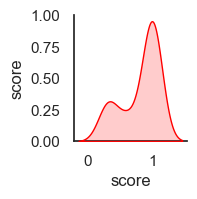


optimizing_time (min) = 0.0


In [58]:
# Initiating
t1 = time.time()

### Optimizing by G.A.
Pop_Size, Gens, Tours, Crossover, Mutation = 500,2,1500, .30,.60 
Search_Space_Features   = [ 'score' ]
Best_Params, Top_Params = GA_Search(CATs,TFs,INTs,CONTs,ESTIMATOR,CV,Search_Space_Features,SCORING,
                                    Pop_Size,Gens,Tours,Crossover,Mutation,
                                    X_Train, y_Train, X_Valid, y_Valid )

t2 = time.time()
dt = np.round( (t2-t1)/60, 0 )
print( '\noptimizing_time (min) =', dt )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making DTree

In [59]:
DTree = DecisionTreeClassifier(
    splitter='best', criterion='log_loss', max_features=None, max_depth=4, max_leaf_nodes=13,
    ccp_alpha=0.00910226805408365, min_samples_leaf=0.0027485377033029034, min_samples_split=0.0022476517962994325,
    min_impurity_decrease=0.005714296619213639, min_weight_fraction_leaf=0.015314697914714633,
    class_weight={1:CLASS_WEIGHT}, random_state=RANDOM_STATE 
                               ).fit( X_Train, y_Train )

pickle.dump( DTree,  open('DTree','wb') )  # save
DTree = pickle.load( open('DTree','rb') )  # load

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Comparing DTree with BaseLine on Validation Data

In [60]:
y_Pred_DTree = DTree.predict( X_Valid )
DTree_Report = classification_report( y_Valid, y_Pred_DTree )
print( '\nDTree\n', DTree_Report )

print( '\nDTree_BaseLine\n', DTree_BaseLine_Report )


DTree
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


DTree_BaseLine
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - By Optimization:
    - **Precision** of **Class 0** Improved **+4 %**
    - **Precision** of **Class 1** Improved **+4 %**
    - **Recall** of **Class 0** Improved **0 %**
    - **Recall** of **Class 1** Improved **+9 %**
    - **Accuracy** of **Model** Improved **+3 %**
****
 - Accuracy, Recall or Precision **< 80%** and need Boosting.

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Gradient Boosting 

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Preparing Hyper-Parameters

In [62]:
# Needed Data
N_SPLITS = 10

# cross-validation strategy
CV = StratifiedKFold( n_splits=N_SPLITS, shuffle=True )

# (auto)
nClasses = len( Classes )
if nClasses == 2:
    LOSS_VALUES = ['log_loss','exponential']
else:
    LOSS_VALUES = ['log_loss']

# Hyper Parameters
CATs  = [ ['loss'        ,      LOSS_VALUES                 ]   
        , ['criterion'   , ['friedman_mse','squared_error'] ] 
        , ['max_features', ['sqrt','log2',None]             ]  
        ]
TFs   = [ ['warm_start']
        ]
INTs  = [ ['max_depth'     ,            1,  15, 15          ]
        , ['max_leaf_nodes',            2,  16, 15          ]
        , ['n_estimators'  ,            5, 101, 97          ]
        ,   
        ]
CONTs = [ [ 'tol'                     ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'ccp_alpha'               ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'subsample'               ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'learning_rate'           ,   1e-3, 0.3, 4,   'log-uniform' ]
        , [ 'min_samples_leaf'        ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'min_samples_split'       ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'min_impurity_decrease'   ,   1e-3, 1.0, 4,   'log-uniform' ]
        , [ 'min_weight_fraction_leaf',   1e-3, 0.5, 4,   'log-uniform' ]
        ]

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Tuning Hyper-Parameters

initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	2     	1      	0          	1          	1          
1  	4     	1      	0          	1          	1          
2  	3     	1      	0          	1          	1          


Best Parameters: {'loss': 'log_loss', 'criterion': 'friedman_mse', 'max_features': 'sqrt', 'warm_start': False, 'max_depth': 8, 'max_leaf_nodes': 9, 'n_estimators': 89, 'tol': 0.00831596065495762, 'ccp_alpha': 0.0012775206446928782, 'subsample': 0.08197200064949393, 'learning_rate': 0.09193624170370704, 'min_samples_leaf': 0.11280603233112184, 'min_samples_split': 0.04974138358415054, 'min_impurity_decrease': 0.09516217679326297, 'min_weight_fraction_leaf': 0.3227267174954413}
accuracy = 1.0


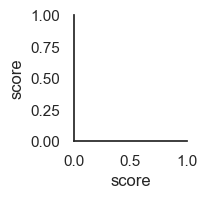


optimizing_time (min) = 0.0


In [63]:
# (manual)
INIT = DTree
#N_ESTIMATORS = 50

Pop_Size, Gens, Tours, Crossover, Mutation = 200,2,600, .30,.60 
Search_Space_Features = [ 'score' ]

# (auto)
# Initiating
t1 = time.time()
# General Estimator 
ESTIMATOR  =  GradientBoostingClassifier( init                = DTree
                                        #, n_estimators        = N_ESTIMATORS
                                        , random_state        = RANDOM_STATE
                                        , verbose             = 0
                                        , n_iter_no_change    = None
                                        , validation_fraction = 0.1 
                                        )   
Best_Params, Top_Params = GA_Search( CATs,TFs,INTs,CONTs, ESTIMATOR, CV, Search_Space_Features, SCORING,
                                     Pop_Size,Gens,Tours,Crossover,Mutation, 
                                     X_Train, y_Train, X_Valid, y_Valid )
t2 = time.time()
dt = np.round( (t2-t1)/60, 0 )
print( '\noptimizing_time (min) =', dt )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making Gradient Boosted Decision Tree

In [65]:
DTree_GrBoosted = GradientBoostingClassifier( init=DTree,
    loss='log_loss', criterion='friedman_mse', max_features='sqrt', warm_start=True, max_depth=15, max_leaf_nodes=11,
    n_estimators=34, tol=0.03714672463925013, ccp_alpha=0.0018269715079550443, subsample=0.568271520205717, 
    learning_rate=0.04537202937412656, min_samples_leaf=0.017651468847492358, min_samples_split=0.03137203929639306, 
    min_impurity_decrease=0.14695670115656753, min_weight_fraction_leaf=0.015398365634094493,
    random_state=RANDOM_STATE, verbose=0, n_iter_no_change=None, validation_fraction=0.1 
                                             ).fit( X_Train, y_Train )

pickle.dump( DTree_GrBoosted,  open('DTree_GrBoosted','wb') )  # save
DTree_GrBoosted = pickle.load( open('DTree_GrBoosted','rb') )  # load

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Comparing Gradient Boosted Decision Tree with BaseLine on Validation Data

In [66]:
y_Pred = DTree_GrBoosted.predict( X_Valid )
DTree_GrBoosted_Report = classification_report( y_Valid, y_Pred )
print( '\nDTree_GrBoosted\n', DTree_GrBoosted_Report )

print( '\nDTree\n'          , DTree_Report           )
print( '\nDTree_BaseLine\n' , DTree_BaseLine_Report  )


DTree_GrBoosted
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


DTree
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


DTree_BaseLine
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.0

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - By Optimization:
    - **Precision** of **Class 0** Improved **+2 %**
    - **Precision** of **Class 1** Improved **+15 %**
    - **Recall** of **Class 0** Improved **+10 %**
    - **Recall** of **Class 1** Improved **0 %**
    - **Accuracy** of **Model** Improved **+6 %**

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Adaptive Boosting 

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Preparing Hyper-Parameters

In [67]:
# Needed Data
N_SPLITS = 10

# cross-validation strategy
CV = StratifiedKFold( n_splits=N_SPLITS, shuffle=True )

# (auto) 
# Hyper Parameters
CATs  = [ ['algorithm'     ,        ['SAMME.R','SAMME']        ]   
        ]
TFs   = [ 
        ]
INTs  = [ ['n_estimators'  ,             5, 101, 97            ]
        ]
CONTs = [ [ 'learning_rate',   1e-3, 0.3, 4,   'log-uniform'   ] 
        ]

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Tuning Hyper-Parameters

initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	2     	1      	0          	1          	1          
1  	4     	1      	0          	1          	1          
2  	3     	1      	0          	1          	1          


Best Parameters: {'algorithm': 'SAMME.R', 'n_estimators': 51, 'learning_rate': 0.023445224781384548}
accuracy = 1.0


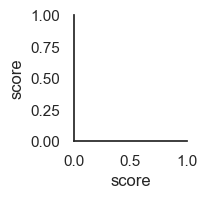


optimizing_time (min) = 0.0


In [69]:
# (manual)
INIT = DTree
#N_ESTIMATORS = 50

Pop_Size, Gens, Tours, Crossover, Mutation = 200,2,600, .30,.60 
Search_Space_Features = [ 'score' ]

# (auto)
# Initiating
t1 = time.time()
# General Estimator 
ESTIMATOR  =  AdaBoostClassifier( estimator    = INIT
                                #,n_estimators = N_ESTIMATORS
                                , random_state = RANDOM_STATE  
                                )   
Best_Params, Top_Params = GA_Search( CATs,TFs,INTs,CONTs, ESTIMATOR, CV, Search_Space_Features, SCORING,
                                     Pop_Size,Gens,Tours,Crossover,Mutation, 
                                     X_Train, y_Train, X_Valid, y_Valid )
t2 = time.time()
dt = np.round( (t2-t1)/60, 0 )
print( '\noptimizing_time (min) =', dt )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making Adaptive Boosted Decision Tree

In [70]:
DTree_AdaBoosted = AdaBoostClassifier( estimator=DTree, random_state=RANDOM_STATE,
    algorithm='SAMME.R', n_estimators=64, learning_rate=0.054921060854881416,
                                     ).fit( X_Train, y_Train )

pickle.dump( DTree_AdaBoosted,  open('DTree_AdaBoosted','wb') )  # save
DTree_AdaBoosted = pickle.load( open('DTree_AdaBoosted','rb') )  # load

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Comparing Adaptive Boosted Decision Tree with BaseLine on Validation Data

In [71]:
y_Pred = DTree_AdaBoosted.predict( X_Valid )
DTree_AdaBoosted_Report = classification_report( y_Valid, y_Pred )
print( '\nDTree_AdaBoosted\n', DTree_AdaBoosted_Report )

print( '\nDTree_GrBoosted\n' , DTree_GrBoosted_Report  )
print( '\nDTree\n'           , DTree_Report            )
print( '\nDTree_BaseLine\n'  , DTree_BaseLine_Report   )


DTree_AdaBoosted
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


DTree_GrBoosted
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


DTree
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report: 
 - By Optimization:
    - **Precision** of **Class 0** Improved **+8 %**
    - **Precision** of **Class 1** Improved **+9 %**
    - **Recall** of **Class 0** Improved **+1 %**
    - **Recall** of **Class 1** Improved **+19 %**
    - **Accuracy** of **Model** Improved **+7 %**

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making Stacker

In [72]:
level0 = list()
#level0.append(( 'DTree_BaseLine'    , DTree_BaseLine     ))
level0.append(( 'DTree'             , DTree              )) 
level0.append(( 'DTree_GrBoosted'   , DTree_GrBoosted    ))
#level0.append(( 'DTree_AdaBoosted'  , DTree_AdaBoosted   ))  

# define meta learner model
level1  =  LogisticRegression()

# define the stacking ensemble
DTree_Stacker =  StackingClassifier( estimators=level0, final_estimator=level1, cv=10, 
                                     passthrough=True,  stack_method='predict_proba' 
                                   ).fit( X_Train, y_Train )

pickle.dump( DTree_Stacker,  open('DTree_Stacker','wb') )  # save
DTree_Stacker = pickle.load( open('DTree_Stacker','rb') )  # load

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Comparing Stacker Decision Tree with BaseLine on Validation Data

In [73]:
y_Pred = DTree_Stacker.predict( X_Valid )
DTree_Stacker_Report = classification_report( y_Valid, y_Pred )
print( '\nDTree_Stacker\n'   , DTree_Stacker_Report    )

print( '\nDTree_AdaBoosted\n', DTree_AdaBoosted_Report )
print( '\nDTree_GrBoosted\n' , DTree_GrBoosted_Report  )
print( '\nDTree\n'           , DTree_Report            )
print( '\nDTree_BaseLine\n'  , DTree_BaseLine_Report   )


DTree_Stacker
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


DTree_AdaBoosted
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


DTree_GrBoosted
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.0

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making Voter

In [74]:
level0 = list()
#level0.append(( 'DTree_BaseLine'    , DTree_BaseLine     ))
#level0.append(( 'DTree'             , DTree              )) 
level0.append(( 'DTree_GrBoosted'   , DTree_GrBoosted    ))
level0.append(( 'DTree_AdaBoosted'  , DTree_AdaBoosted   ))  

# define meta learner model
level1  =  LogisticRegression()

# define the votinging ensemble
DTree_Voter = VotingClassifier( estimators=level0, voting='soft' ).fit( X_Train, y_Train ) 

pickle.dump( DTree_Voter,  open('DTree_Voter','wb') )  # save
DTree_Voter = pickle.load( open('DTree_Voter','rb') )  # load

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Comparing Stacker Decision Tree with BaseLine on Validation Data

In [75]:
y_Pred = DTree_Voter.predict( X_Valid )
DTree_Voter_Report = classification_report( y_Valid, y_Pred )
print( '\nDTree_Voter\n'   , DTree_Voter_Report    )

print( '\nDTree_AdaBoosted\n', DTree_AdaBoosted_Report )
print( '\nDTree_GrBoosted\n' , DTree_GrBoosted_Report  )
print( '\nDTree\n'           , DTree_Report            )
print( '\nDTree_BaseLine\n'  , DTree_BaseLine_Report   )


DTree_Voter
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


DTree_AdaBoosted
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22


DTree_GrBoosted
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00 

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.7em; color:#00b3e5;"> Checking Accuracy, Recall and Precision of Estimators on Validation Data

In [76]:
ESTIMATORS = [  DTree_BaseLine ,  DTree ,  DTree_GrBoosted ,  DTree_AdaBoosted , 
                DTree_Stacker  ,  DTree_Voter  ]
LABELS     = [ 'DTree_BaseLine', 'DTree', 'DTree_GrBoosted', 'DTree_AdaBoosted',
               'DTree_Stacker' , 'DTree_Voter' ]

ACCURACIS, RECALLS, PRECISIONS = [],[],[]

for estimator in ESTIMATORS:
    y_pred  = estimator.predict( X_Valid )
    
    A_Score =  accuracy_score(y_Valid, y_pred,        normalize=True        )
    R_Score =    recall_score(y_Valid, y_pred, average=None, zero_division=1)  
    P_Score = precision_score(y_Valid, y_pred, average=None, zero_division=1)
    
    A_Score=np.round(A_Score*100,0);   ACCURACIS.append(A_Score)
    R_Score=np.round(R_Score*100,0);     RECALLS.append(R_Score)
    P_Score=np.round(P_Score*100,0);  PRECISIONS.append(P_Score)
    
Estimators_ARP = pd.DataFrame([ACCURACIS,RECALLS,PRECISIONS]).T
Estimators_ARP.columns = [ 'Accuracy','Recalls','Precisions' ]
Estimators_ARP.index   = LABELS

cm = sns.light_palette('#ffcccb', as_cmap=True)
Estimators_ARP.style.background_gradient(subset=['Accuracy'], cmap=cm).format(precision=1)

,Accuracy,Recalls,Precisions
DTree_BaseLine,100.0,[100. 100. 100.],[100. 100. 100.]
DTree,100.0,[100. 100. 100.],[100. 100. 100.]
DTree_GrBoosted,100.0,[100. 100. 100.],[100. 100. 100.]
DTree_AdaBoosted,100.0,[100. 100. 100.],[100. 100. 100.]
DTree_Stacker,100.0,[100. 100. 100.],[100. 100. 100.]
DTree_Voter,100.0,[100. 100. 100.],[100. 100. 100.]


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
 - Considering the recall, **DTree_Voter** is the best estimator 

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Comparing The Performance of Estimators on Test Data

In [79]:
models = dict() 
models['DTree_BaseLine'    ] = DTree_BaseLine
models['DTree'             ] = DTree
models['DTree_GrBoosted'   ] = DTree_GrBoosted
models['DTree_AdaBoosted'  ] = DTree_AdaBoosted 
models['DTree_Stacker'     ] = DTree_Stacker
models['DTree_Voter'       ] = DTree_Voter
 

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

results, names = list(), list()
print('                      Mean     SD       95% CI') 
for name, model in models.items():
    scores = evaluate_model( model, X_Test, y_Test )
    results.append(scores)
    names.append(name)
    print('>%19s  %.3f  (%.3f)  [%.2f %.2f]' % (name, mean(scores), std(scores), mean(scores)-2*std(scores), mean(scores)+2*std(scores)   ))
    
# plot model performance for comparison
plt.boxplot( results, labels=names, showmeans=True ); plt.xticks(rotation=90); plt.grid(False); plt.show()

                      Mean     SD       95% CI
>     DTree_BaseLine  1.000  (0.000)  [1.00 1.00]
>              DTree  1.000  (0.000)  [1.00 1.00]
>    DTree_GrBoosted  1.000  (0.000)  [1.00 1.00]
>   DTree_AdaBoosted  0.914  (0.087)  [0.74 1.09]


ValueError: n_splits=10 cannot be greater than the number of members in each class.

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report
 - **DTree_Voter** performed just fine.

** **

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Evaluating DTree_AdaBoosted

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Visualizing

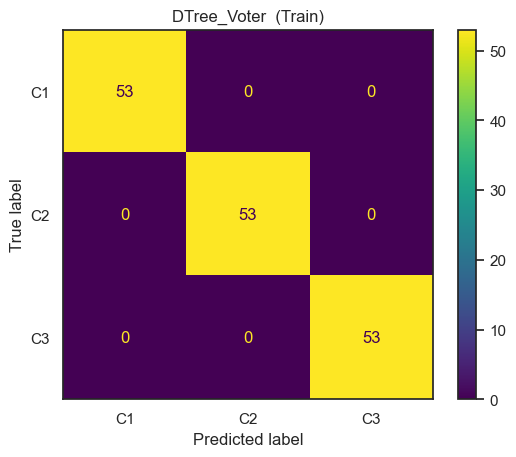

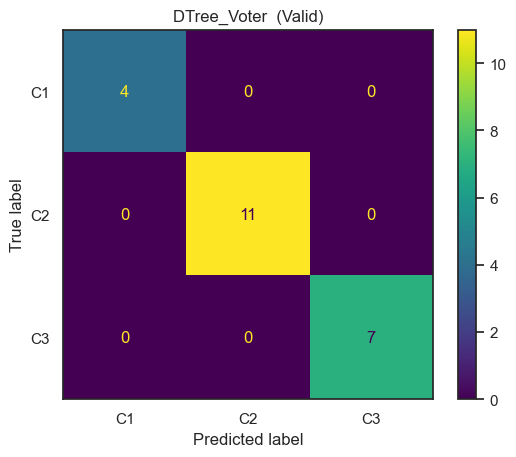

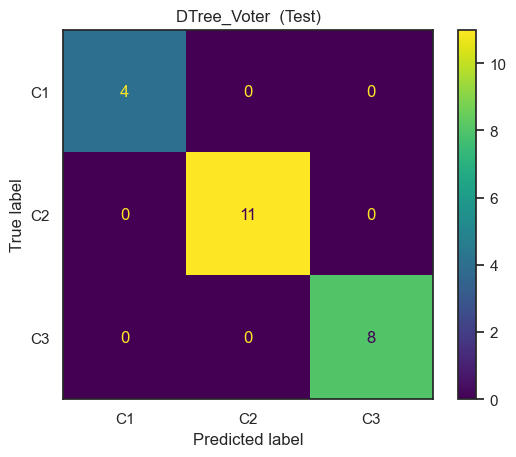

In [82]:
CLF      =  DTree_Voter
CLF_Name = 'DTree_Voter'

# Training Performance
figure = ConfusionMatrixDisplay.from_estimator( CLF, X_Train, y_Train, display_labels=Classes )
plt.title( CLF_Name+'  (Train)' ); plt.show()

# Valid Performance   
disp = ConfusionMatrixDisplay.from_estimator( CLF, X_Valid, y_Valid, display_labels=Classes  )
plt.title( CLF_Name+'  (Valid)' ); plt.show()

# Test Performance
disp = ConfusionMatrixDisplay.from_estimator( CLF, X_Test,  y_Test,  display_labels=Classes  )
plt.title( CLF_Name+'  (Test)' ); plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Comparing DTree_Voter with BaseLine on Test Data

In [83]:
y_Pred = CLF.predict( X_Test )
Report = classification_report( y_Test, y_Pred )
print( '\n'+CLF_Name,  '\n', Report )

y_Pred = DTree_BaseLine.predict( X_Test )
Report = classification_report( y_Test, y_Pred )
print( '\nDTree_BaseLine\n', Report )


DTree_Voter 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         8

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23


DTree_BaseLine
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         8

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



##### 
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Report:
 - Compared to BaseLine:
 
   - **precision** of class 0 **improved +11%**
   - **precision** of class 1 **improved +6%**
    
   - **recall** of class 0 **improved -4%**
   - **recall** of class 1 **improved +25%**
   
   - **accuracy improved +6%**
**  **
 - Justification: As the Optimized Estimator is the fruit of **Cross-Validation** and **Adaptive-Boosting**, it is more **Reliable** than the BaseLine.

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving Estimators To Disk

In [84]:
ESTIMATORS       = [  DTree_BaseLine ,  DTree ,  DTree_GrBoosted ,  DTree_AdaBoosted ,  DTree_Stacker ,  DTree_Voter  ]
ESTIMATORS_Names = [ 'DTree_BaseLine', 'DTree', 'DTree_GrBoosted', 'DTree_AdaBoosted', 'DTree_Stacker', 'DTree_Voter' ]

for i in range( len(ESTIMATORS) ):
    Estimator        = ESTIMATORS[ i ]
    Destination_File = ESTIMATORS_Names[ i ]+'.sav'
    pickle.dump( Estimator, open(Destination_File,'wb') )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Estimators From Disk

In [85]:
DTree_BaseLine   = pickle.load( open( 'DTree_BaseLine.sav'  ,'rb') )
DTree            = pickle.load( open( 'DTree.sav'           ,'rb') ) 
DTree_GrBoosted  = pickle.load( open( 'DTree_GrBoosted.sav' ,'rb') )
DTree_AdaBoosted = pickle.load( open( 'DTree_AdaBoosted.sav','rb') )
DTree_Stacker    = pickle.load( open( 'DTree_Stacker.sav'   ,'rb') )
DTree_Voter      = pickle.load( open( 'DTree_Voter.sav'     ,'rb') )

** **

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Making The Final Estimator

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Checkig Range of Features

In [115]:
round( X_Train.describe().T[['min','max']], 3 )

,min,max
Blood_Plasma,44.0,199.0
Test,14.0,440.0
Body_Mass_Index,18.2,52.9
Skin,7.0,56.0
Age,21.0,68.0
Pregnancy,0.0,13.0
Blood_Pressure,38.0,108.0


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Choosing A Random Record To Be Predicted

In [116]:
# choosing a record in the test data set to be predicted
record_number = 10

print( np.round( X_Test.iloc[ record_number, : ], 1 ) )
print( '\nExpected_Class = ', y_Test[ record_number ] )

Blood_Plasma       117.0
Test               120.0
Body_Mass_Index     33.2
Skin                27.0
Age                 24.0
Pregnancy            4.0
Blood_Pressure      64.0
Name: 10, dtype: float64

Expected_Class =  0


<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Entering The Record of Interest and Acceptable Range

In [117]:
# input data                R  a  n  g  e  

Blood_Plasma    = 166.0     # 61.0  199.0
Test            = 175.0     # 14.0  465.0
Body_Mass_Index =  25.8     # 18.2   52.9
Skin            =  19.0     #  7.0   56.0
Age             =  51.0     # 21.0   68.0
Pregnancy       =   5.0     #  0.0   13.0
Blood_Pressure  =  72.0     # 38.0  108.0

#Class          =   1.0    

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Predicting 

In [120]:
# x 
x = X_Train.copy()

# s  written in the same order as  X_Train
s = [ Test, Blood_Plasma, Age, Skin, Pregnancy, Body_Mass_Index, Blood_Pressure ]

# encode_columns
encode_columns = [] 

def predicted_class( s, x, encode_columns ):
    s  = pd.DataFrame( [s.copy(),s.copy()], columns=x.columns )
    sx = pd.concat( [s,x], axis=0 )
    sx_encoded = pd.get_dummies(
          sx
        , columns = encode_columns
        )
    sx_encoded = sx_encoded.iloc[[0,1],:] 
    sx_scaled  = pd.DataFrame( Scaler.transform(sx_encoded), columns=sx_encoded.columns ) 
    
    Estimator_Name, pred = [], [] 
    for key, value in models.items():
        clf = value
        Estimation = clf.predict( sx_scaled )[0]
        pred.append( Estimation ) 
        Estimator_Name.append( key )
        
    df_pred = pd.DataFrame( [pred] ).T
    df_pred.columns = ['Predicted Class']
    df_pred.index   = Estimator_Name
    
    return df_pred 

# Predicting
df_pred = predicted_class( s, x, encode_columns )
df_pred

,Predicted Class
DTree_BaseLine,1
DTree,1
DTree_GrBoosted,1
DTree_AdaBoosted,1
DTree_Stacker,1
DTree_Voter,1


#####   

#####   